In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import prepare_inference_combined
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

In [2]:
blue = '#1F449C'
pink = '#E57A77'

In [88]:
def stats_comparison_plot(combined, conjugate):
    color_combined = blue
    color_conjugate = pink
    plt.axvline(x=sps.describe(conjugate).mean, color=color_conjugate, label='Conjugate')
    plt.axvspan(xmin=(sps.describe(conjugate).mean - np.sqrt(sps.describe(conjugate).variance))[0], xmax=(sps.describe(conjugate).mean + np.sqrt(sps.describe(conjugate).variance))[0], alpha=0.6, color=color_conjugate, label='Conjugate std')
    plt.axvline(x=sps.describe(combined).mean, color=color_combined, label='Combined')
    plt.axvspan(xmin=(sps.describe(combined).mean - np.sqrt(sps.describe(combined).variance))[0], xmax=(sps.describe(combined).mean + np.sqrt(sps.describe(combined).variance))[0], alpha=0.6, color=color_combined, label='Combined std')
    plt.legend()
    plt.title(f'{len(combined)} Draws')

In [98]:
sps.describe(conjugate[0]).variance

array([3.2604726])

In [108]:
sps.iqr(combined[0], rng=(16, 84))

4.231824117079399

In [109]:
def stats_comparison_plot(combined, conjugate, rng):
    color_combined = blue
    color_conjugate = pink
    plt.axvline(x=sps.describe(conjugate).mean, color=color_conjugate, label='Conjugate')
    plt.axvspan(xmin=(sps.describe(conjugate).mean - sps.iqr(conjugate, rng=rng))[0], xmax=(sps.describe(conjugate).mean + sps.iqr(conjugate, rng=rng))[0], alpha=0.6, color=color_conjugate, label='Conjugate std')
    plt.axvline(x=sps.describe(combined).mean, color=color_combined, label='Combined')
    plt.axvspan(xmin=(sps.describe(combined).mean - sps.iqr(combined, rng=rng))[0], xmax=(sps.describe(combined).mean + sps.iqr(combined, rng=rng))[0], alpha=0.6, color=color_combined, label='Combined std')
    plt.legend()
    plt.title(f'{len(combined)} Draws, range = {rng}')

## Comparing Combined / Conjugate for Poisson Constraints

In [3]:
model = pyhf.simplemodels.uncorrelated_background([120, 120], [10, 10], [120, 120])
data = [130, 130]
auxdata = model.config.auxdata

unconstr_priors = {
    #'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]},
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [89]:
n_draws = 500_000

#### Conjugate

(19 s)

In [90]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=n_draws, chains=1, step=step)
    # post_pred = pm.sample_posterior_predictive(post_data)
    # prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Metropolis: [uncorr_bkguncrt]


/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 500_000 draw iterations (1_000 + 500_000 draws total) took 230 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (500000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_Data]


#### Combined

(26 s)

In [91]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=n_draws, chains=1, step=step)
    # post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained_Gammas]
>Metropolis: [Gammas]


Sampling 1 chain for 1_000 tune and 500_000 draw iterations (1_000 + 500_000 draws total) took 283 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (500000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_ActData, Expected_AuxData]


#### Comparison Posterior

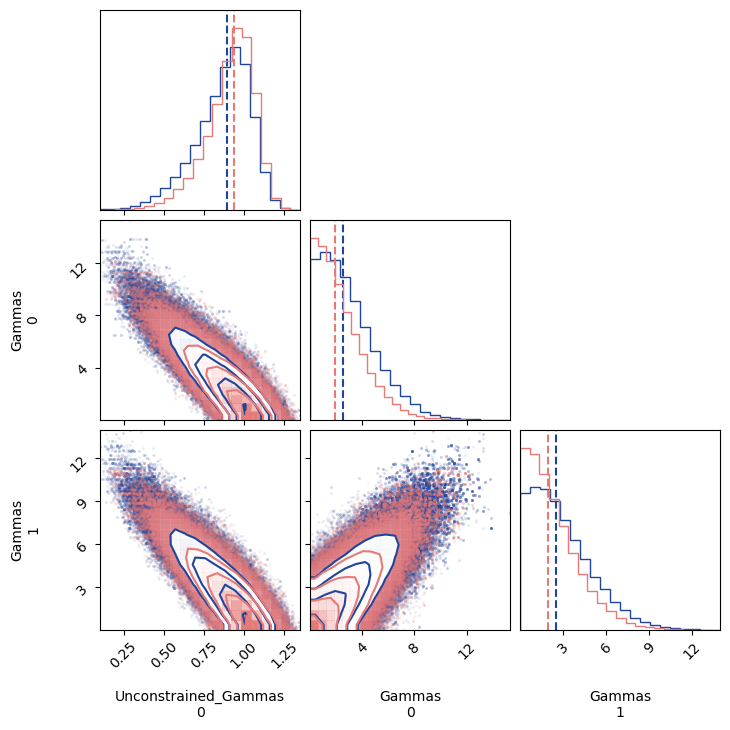

In [92]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

In [94]:
combined = [post_data.posterior.uncorr_bkguncrt.T[0], post_data.posterior.uncorr_bkguncrt.T[1]]
conjugate = [post_data_combined.posterior.Gammas.T[0], post_data_combined.posterior.Gammas.T[1]]

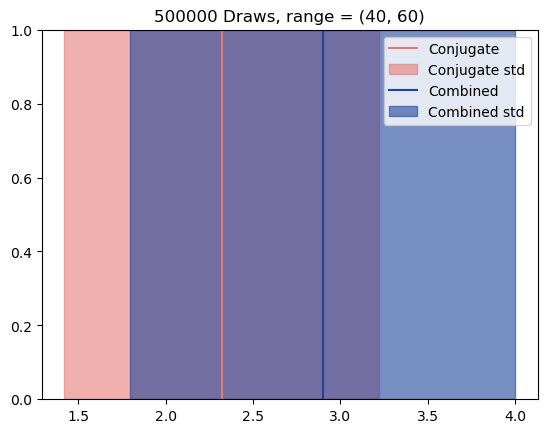

In [114]:
stats_comparison_plot(combined[0], conjugate[0], rng=(40, 60))

## Combined / Conjugate for Normal constraints

In [115]:
model = pyhf.simplemodels.correlated_background([120, 120], [10, 10], [130, 130], [110, 110])
data = [130, 130]
auxdata = model.config.auxdata

In [116]:
unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [5]},
    # 'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

#### Conjugate

In [117]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=n_draws, chains=1, step=step)
    # post_pred = pm.sample_posterior_predictive(post_data)
    # prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [correlated_bkg_uncertainty]
>Metropolis: [mu]


Sampling 1 chain for 1_000 tune and 500_000 draw iterations (1_000 + 500_000 draws total) took 188 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (500000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


#### Combined

(26 s)

In [119]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=n_draws, chains=1, step=step)
    # post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained_HalfNormals]
>Metropolis: [Normals]


Sampling 1 chain for 1_000 tune and 500_000 draw iterations (1_000 + 500_000 draws total) took 225 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (500000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_ActData, Expected_AuxData]


In [130]:
post_data.posterior.correlated_bkg_uncertainty.T[0]

<xarray.DataArray 'correlated_bkg_uncertainty' (draw: 500000, chain: 1)>
array([[-0.45306066],
       [-0.45306066],
       [-0.45306066],
       ...,
       [ 0.66692895],
       [ 0.66692895],
       [ 0.66692895]])
Coordinates:
  * chain                             (chain) int64 0
  * draw                              (draw) int64 0 1 2 ... 499998 499999
    correlated_bkg_uncertainty_dim_0  int64 0

In [134]:
combined = [post_data.posterior.correlated_bkg_uncertainty.T[0]]
conjugate = [post_data_combined.posterior.Normals.T[0]]

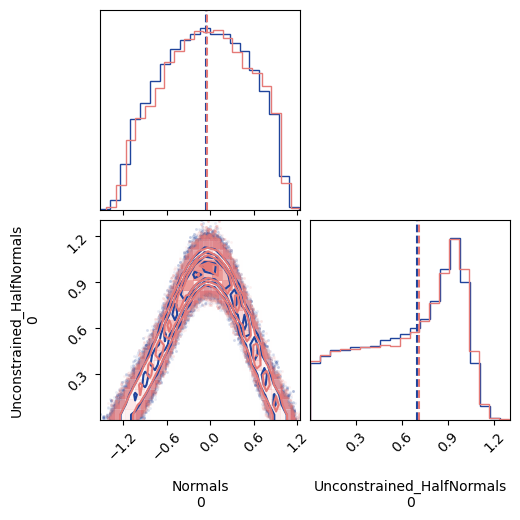

In [121]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

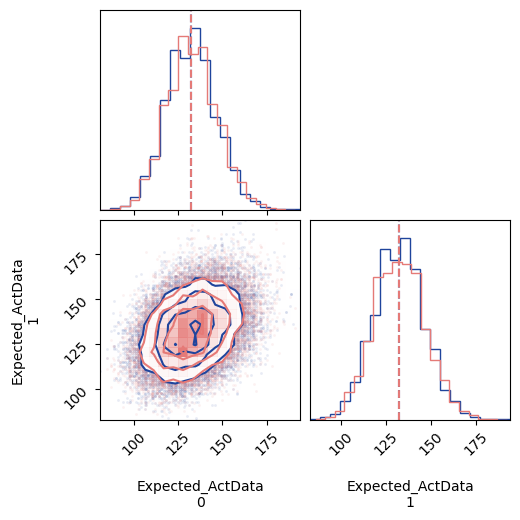

In [98]:
# Metropolis 28_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);

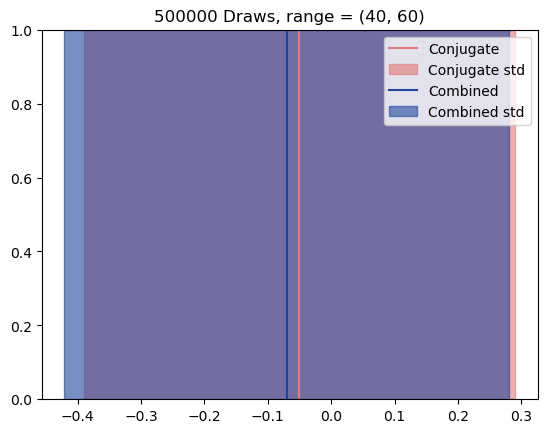

In [135]:
stats_comparison_plot(combined[0], conjugate[0], rng=(40, 60))

## Combined / Conjugate for Poisson and Normal constaints

In [108]:
model = pyhf.Model(
        {'channels': [{'name': 'singlechannel',
        'samples': [
        {'name': 'signal',
        'data': [10, 20],
        'modifiers': [
            {'name': 'mu', 'type': 'normfactor', 'data': None},
            # {'name': 'mu2', 'type': 'normfactor', 'data': None}
            ]},
        {'name': 'background',
        'data': [120, 110],
        'modifiers': [
            # Correlated / Normal
            {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [200, 190], 'lo_data': [90, 95]}},
            # Uncorrelated / Poisson
            {'name': 'uncorr_bkg', 'type': 'shapesys','data': [120, 120]}
            ]}]}]
            }
        )

data = [110, 105]
auxdata = model.expected_auxdata(model.config.suggested_init())

unconstr_priors = {
    #'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]},
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

In [109]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=28_000, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    # prior_pred = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [corr_bkg]
>Metropolis: [mu]
>Metropolis: [uncorr_bkg]


Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 23 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_Data]


In [110]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=28_000, chains=1, step=step)
    post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained_Gammas]
>Metropolis: [Normals]
>Metropolis: [Gammas]


/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 28 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_ActData, Expected_AuxData]


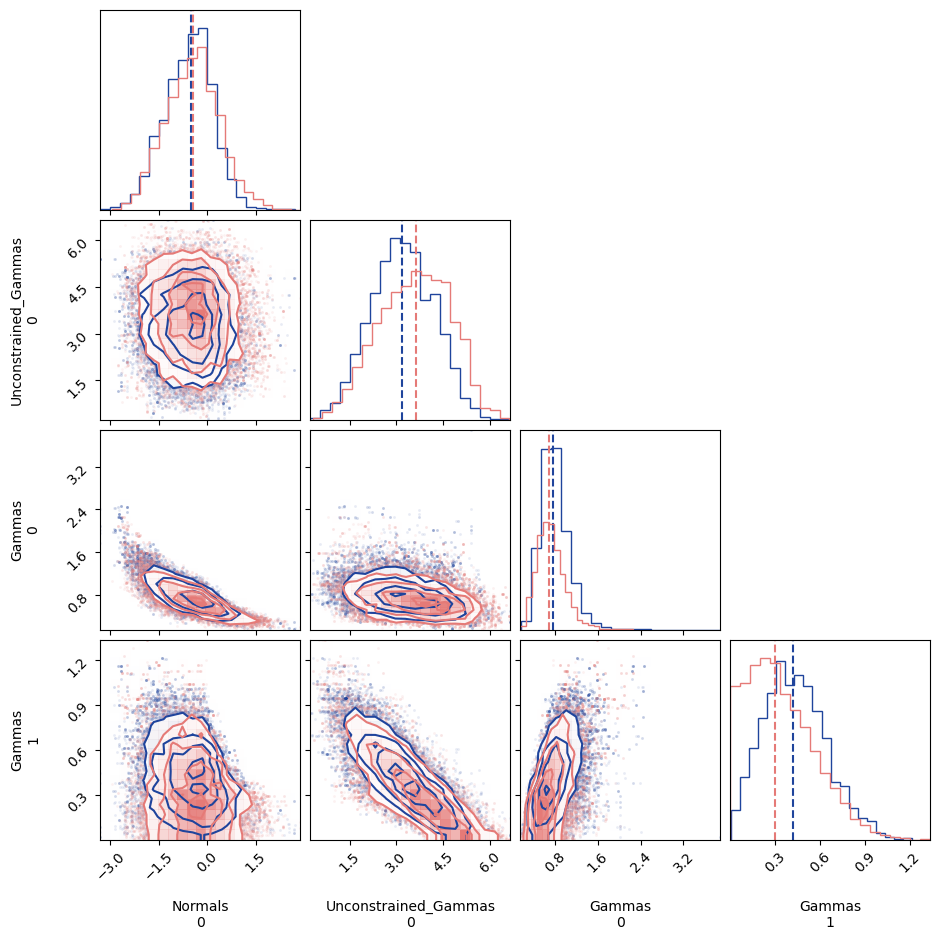

In [112]:
# Metropolis 28_000
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

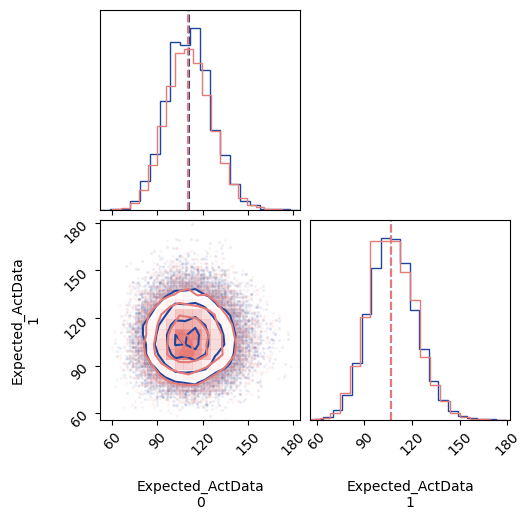

In [113]:
# Metropolis 28_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);

In [114]:
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=28_000, chains=1)#, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    # prior_pred = pm.sample_prior_predictive(10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [corr_bkg, mu, uncorr_bkg]


Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 78 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_Data]


In [115]:
with infer.model_combined(model, unconstr_priors, data, auxdata):
    step = pm.Metropolis()
    post_data_combined = pm.sample(draws=28_000, chains=1)#, step=step)
    post_pred_combined = pm.sample_posterior_predictive(post_data_combined)
    # prior_pred_combined = pm.sample_prior_predictive(10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Unconstrained_Gammas, Normals, Gammas]


Sampling 1 chain for 1_000 tune and 28_000 draw iterations (1_000 + 28_000 draws total) took 111 seconds.
/home/iwsatlas1/mhorstm/Bayesian_pyhf/.conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (28000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_ActData, Expected_AuxData]


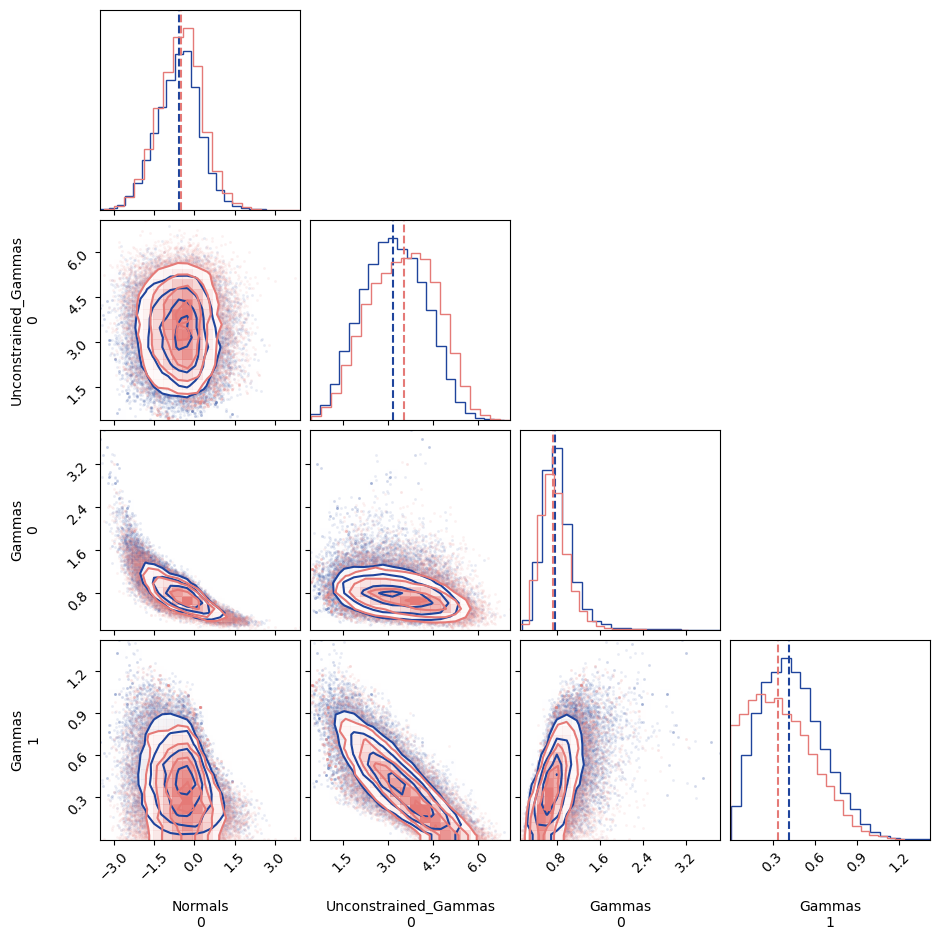

In [116]:
# HMC 28_000
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);
corner.corner(post_data_combined.posterior, quantiles=[0.5], color = pink, fig = a);

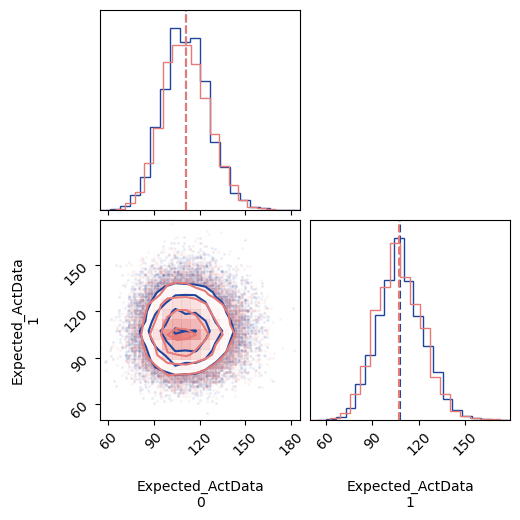

In [117]:
# HMC 28_000
a = corner.corner(post_pred.posterior_predictive.Expected_Data, quantiles=[0.5], color = blue);
corner.corner(post_pred_combined.posterior_predictive.Expected_ActData, quantiles=[0.5], color = pink, fig = a);